In [2]:
import os

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_score, confusion_matrix, ConfusionMatrixDisplay, get_scorer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC

In [3]:
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count()-1)  # To silence warning : Could not find the number of physical cores

In [4]:
randomState = 42

In [5]:
# Function to calculate weighted specificity
def multiclassSpecificity(yTrue, yPredict):
    cm = confusion_matrix(yTrue, yPredict)

    specificities = []
    for i in range(len(cm)):
        trueNegative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        falsePositive = np.sum(cm[:, i]) - cm[i, i]
        specificity = trueNegative / (trueNegative + falsePositive) if (trueNegative + falsePositive) > 0 else 0
        specificities.append(specificity)

    return np.mean(specificities)

#### Read data and define target

In [6]:
df = pd.read_csv('../Dataset/dataFrameProcessed')
targetCol = 'imdb_rating'

Split features and target data

In [7]:
X = df.drop(columns=[targetCol])
y = df[targetCol]

Built set of models selected

In [8]:
models = {
    'Support Vector Machine': SVC(kernel='rbf', random_state=randomState),
    'Random Forest'         : RandomForestClassifier(random_state=randomState),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=randomState),
}

Built scoring metrix

In [9]:
scoringMetrix = {
    'accuracy'    : 'accuracy',
    'precision'   : make_scorer(precision_score, average='weighted', zero_division=1),
    'recall'      : 'recall_weighted',
    'f1'          : 'f1_weighted',
    'specificity' : make_scorer(multiclassSpecificity)
}

Split data (80:20)

In [10]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=randomState , stratify=y)

In [11]:
# Function to make pipeline
def makePipeline(modelToUsed):
    steps = [
        ('over', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)),
        ('scaling', MinMaxScaler().set_output(transform='pandas')),
        ('feature_selection', SelectFromModel(
            estimator=RandomForestClassifier(random_state=randomState, n_jobs=-1),
            threshold='median')),
        ('classifier', modelToUsed),
    ]
    return Pipeline(steps=steps)

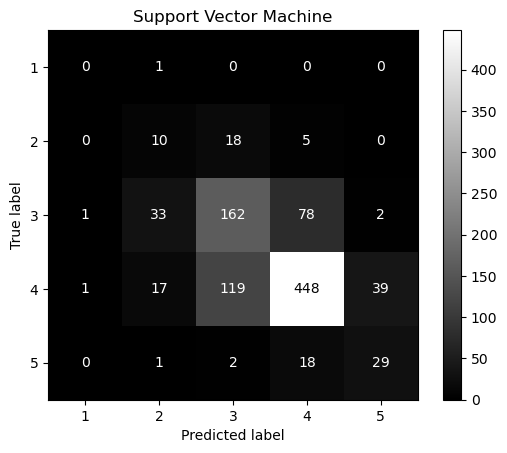

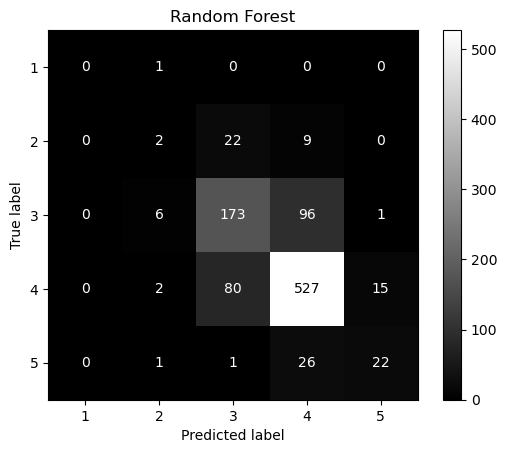

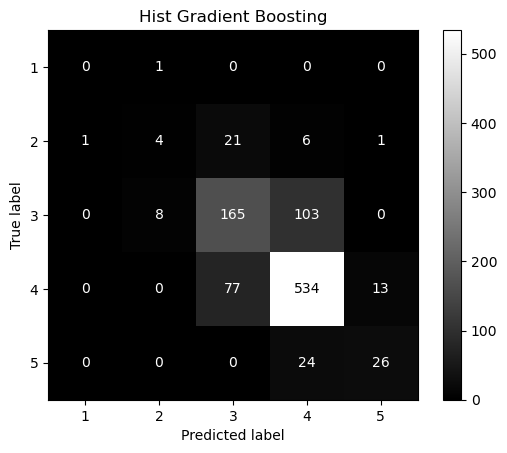

In [12]:
for name, model in models.items():
    # Fit pipeline
    pipeCM = makePipeline(model)
    pipeCM.fit(XTrain, yTrain)

    # Show confusion metrix
    dispCM = ConfusionMatrixDisplay.from_estimator(
        pipeCM,
        XTest,
        yTest,
        cmap='gist_gray',
    )
    dispCM.ax_.set_title(name)
    plt.show()

In [12]:
for name, model in models.items():
    pipeSC = makePipeline(model)
    pipeSC.fit(XTrain, yTrain)

    # Print model name and its results
    print(f'\n{name:<12}')
    for metricName, scorer in scoringMetrix.items():
        scorer = get_scorer(scorer)
        score = scorer(pipeSC, XTest, yTest)
        print(f"{metricName:<12}: {score:.5f}")


Support Vector Machine
accuracy    : 0.65955
precision   : 0.69490
recall      : 0.65955
f1          : 0.67352
specificity : 0.88450

Random Forest
accuracy    : 0.73577
precision   : 0.71973
recall      : 0.73577
f1          : 0.72557
specificity : 0.89260

Hist Gradient Boosting
accuracy    : 0.74085
precision   : 0.72702
recall      : 0.74085
f1          : 0.73153
specificity : 0.89333


In [13]:
dataset_results = []

for name, model in models.items():
    pipeCV = makePipeline(model)

    cvResult = cross_validate(
        pipeCV,
        X,
        y,
        cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState),
        scoring=scoringMetrix,
        n_jobs=-1,
        error_score='raise'
    )

    dataset_results.append({
        'Model'         : name,
        'Accuracy'      : np.mean(cvResult['test_accuracy']),
        'Precision'     : np.mean(cvResult['test_precision']),
        'Recall'        : np.mean(cvResult['test_recall']),
        'F1 Score'      : np.mean(cvResult['test_f1']),
        'Specificity'   : np.mean(cvResult['test_specificity'])
    })

print(pd.DataFrame(dataset_results).set_index('Model'))

                        Accuracy  Precision    Recall  F1 Score  Specificity
Model                                                                       
Support Vector Machine  0.666801   0.709935  0.666801  0.682750     0.890008
Random Forest           0.730029   0.722563  0.730029  0.724174     0.893109
Hist Gradient Boosting  0.744256   0.734465  0.744256  0.736981     0.896896


Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'classifier__l2_regularization': 0.02, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__max_iter': 200, 'classifier__max_leaf_nodes': 20}
accuracy    : 0.74593
precision   : 0.73509
recall      : 0.74593
f1          : 0.73791
specificity : 0.89556


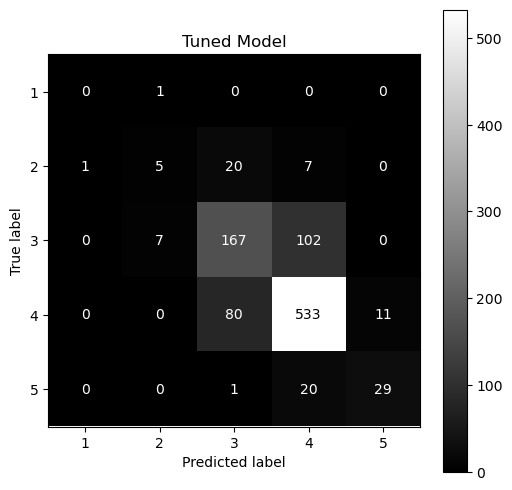

In [17]:
pipeGrid = makePipeline(HistGradientBoostingClassifier(random_state=randomState))

param_grid = {
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__max_iter': [100,  200],
    'classifier__max_depth': [None, 10],
    'classifier__max_leaf_nodes': [10, 20],
    'classifier__l2_regularization': [0.01, 0.02],
}

gridSearch = GridSearchCV(
    estimator=pipeGrid,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=3
)

gridSearch.fit(XTrain, yTrain)

print(gridSearch.best_params_)
for metricName, scorer in scoringMetrix.items():
    scorer = get_scorer(scorer)
    score = scorer(gridSearch, XTest, yTest)
    print(f"{metricName:<12}: {score:.5f}")

yPred = gridSearch.predict(XTest)
confusionMatrix = confusion_matrix(yTest, yPred)
display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=gridSearch.classes_)

fig, axes = plt.subplots(figsize=(6, 6))
display.plot(cmap='gist_gray', ax=axes, values_format='d')
plt.title(f'Tuned Model')
plt.show()